# Clustering Unlabeled Sound Data


In [7]:

#Make allNecessary Imports
# !pip install librosa  -----run this line if you dont have librosa installed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import librosa
import glob
import os



In [9]:
# Define a function to get the label from the file name
def get_label(file):
    return file.split(".")[0].split("/")[-1]

# Path to the unlabelled sounds
data_path = 'unlabelled_sounds/unlabelled_sounds/'

audio_files = glob.glob(os.path.join(data_path, "*.wav"))
X = []
Y = []
n_mfcc = 13
n_chroma = 13

# Function to extract features from an audio file
def extract_features(file_path, sr=22050, n_mfcc=13, n_chroma=13):
    try:
        y, sr = librosa.load(file_path, sr=sr)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=n_chroma)
        
        # Aggregate features (mean and standard deviation)
        features = np.hstack([
            np.mean(mfccs, axis=1), np.std(mfccs, axis=1),
            np.mean(spectral_contrast, axis=1), np.std(spectral_contrast, axis=1),
            np.mean(chroma_stft, axis=1), np.std(chroma_stft, axis=1)
        ])
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Process all files in the directory
for file in audio_files:
    features = extract_features(file)
    if features is not None:
        X.append(features)
        Y.append(get_label(file))

# Convert X and Y to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Convert to a DataFrame
feature_df = pd.DataFrame(X)
feature_df.insert(0, 'label', Y)

# Save features to a CSV file
feature_df.to_csv('sound_features.csv', index=False)

print("Feature extraction completed. Saved to sound_features.csv.")

Feature extraction completed. Saved to sound_features.csv.


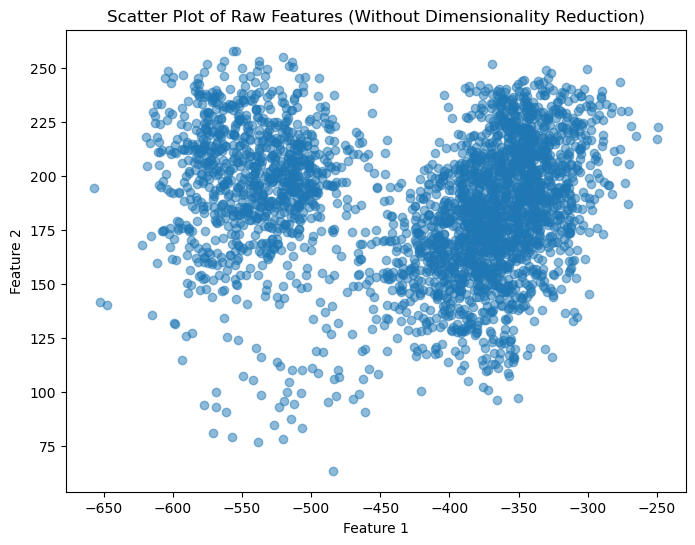

In [15]:

import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
pairplot_df = feature_df.iloc[:, :6]  # First 5 features + label
sns.pairplot(pairplot_df, hue='label')
plt.show()



### Why is dimensionality reduction important?

#### Why dimensionality reduction is important?:
Working with high-dimensional data can be tricky. When we try to visualize raw features in a scatter plot, we usually pick just two dimensions (like Feature 1 and Feature 2), but our dataset likely has way more dimensions. This means we're losing a lot of information in the visualization. Dimensionality reduction techniques like PCA or t-SNE help us project high-dimensional data into a lower-dimensional space while keeping the meaningful patterns.

#### Challenges faced:
1. Raw feature visualization is limited, meaning that with many features, a simple scatter plot doesn't tell us much.
2. Some extracted features might not be relevant: Not every computed feature is useful for clustering.
3. Computational cost: Processing a lot of features for clustering or classification can be expensive.

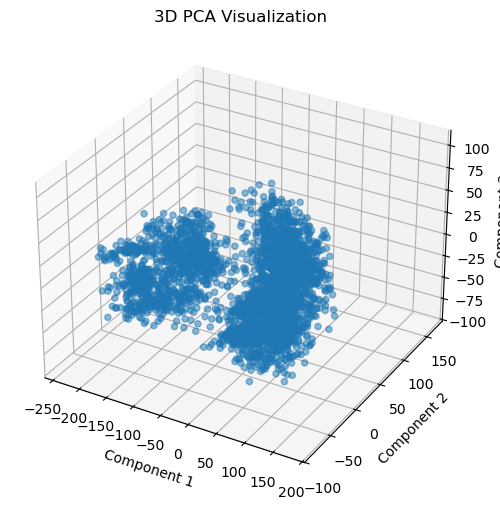

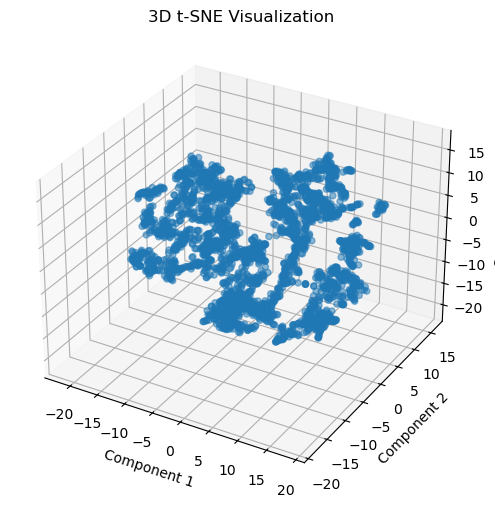

In [18]:
# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(X)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42)
features_tsne = tsne.fit_transform(X)

# 3D Visualization of PCA
def plot_3d(features, title):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(features[:, 0], features[:, 1], features[:, 2], alpha=0.5)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    ax.set_title(title)
    plt.show()

plot_3d(features_pca, "3D PCA Visualization")
plot_3d(features_tsne, "3D t-SNE Visualization")

### Which method (PCA or t-SNE) provides better separability of clusters and why?
From the visualizations, t-SNE tends to provide better cluster separation because it is a non-linear technique that preserves local structures and relationships in the data. PCA, being a linear transformation, captures the global variance but may not always reveal distinct clusters if the data is highly non-linear. In our case, if the t-SNE plot shows more distinct and well-separated clusters than PCA, then it is the better choice for visualization and clustering.

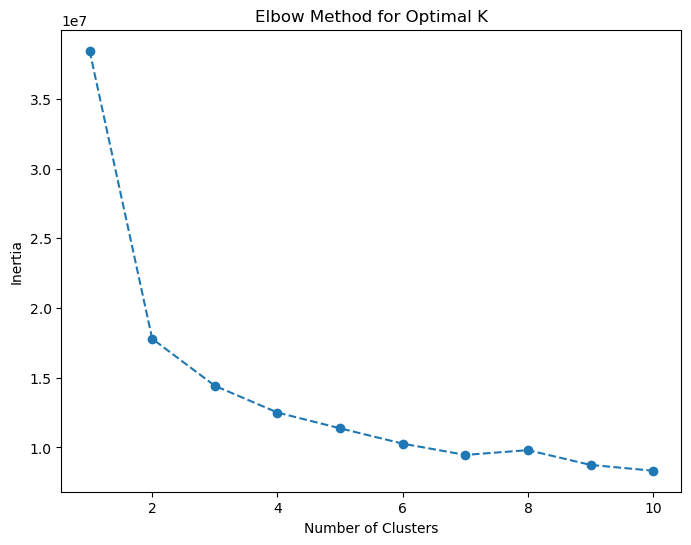

In [25]:

# Optimize number of clusters using Elbow Method
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

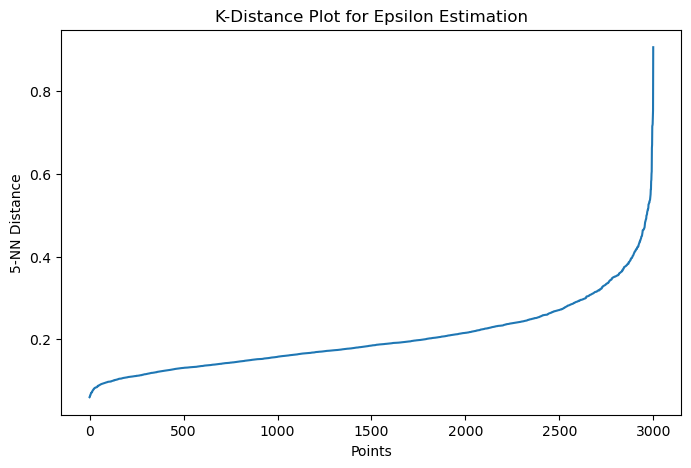

In [55]:
# SI have to scale the features before applying DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_pca) 

# Plotting a graph to find the optimal eq
def plot_kdistance(data, k=5):
    from sklearn.neighbors import NearestNeighbors
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(data)
    distances, _ = neighbors_fit.kneighbors(data)
    distances = np.sort(distances[:, -1], axis=0)
    plt.figure(figsize=(8, 5))
    plt.plot(distances)
    plt.xlabel("Points")
    plt.ylabel(f"{k}-NN Distance")
    plt.title("K-Distance Plot for Epsilon Estimation")
    plt.show()

plot_kdistance(features_scaled, k=5) 

DBSCAN: 1 clusters | Noise points: 6


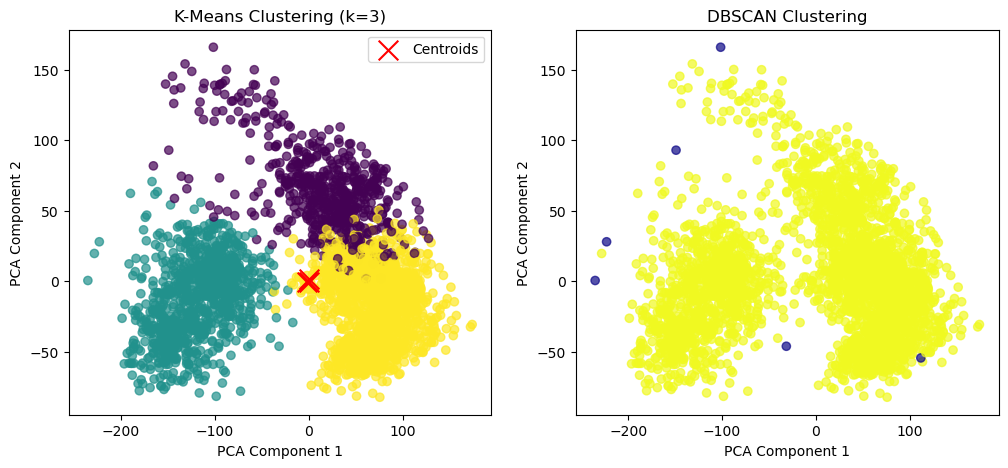

In [61]:
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

# Select optimal K based on elbow method (e.g., k=3 or k=4 based on the previous plot)

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_scaled)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Example tuned values
dbscan_labels = dbscan.fit_predict(features_scaled)

# Check the number of clusters
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"DBSCAN: {n_clusters} clusters | Noise points: {n_noise}")

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap="viridis", alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"K-Means Clustering (k={optimal_k})")
plt.legend()

# Scatter Plot for DBSCAN Clusters
plt.subplot(1, 2, 2)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap="plasma", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering")

plt.show()


In [63]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(X, kmeans_labels)
kmeans_db_index = davies_bouldin_score(X, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(X, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(X, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")

K-Means - Silhouette Score: 0.3412, Davies-Bouldin Index: 1.1932
DBSCAN - Silhouette Score: 0.2650, Davies-Bouldin Index: 2.2664


### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)

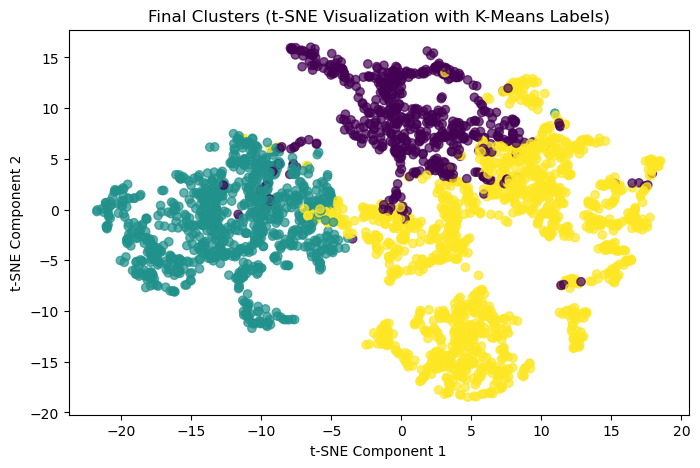

In [65]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering:
          Dimensionality reduction, particularly with PCA and t-SNE, was beneficial in simplifying the complex, high-dimensional audio features, making it easier to visualize and process the data. PCA reduced the data to its most important components, allowing clustering algorithms like K-Means to identify patterns more effectively. t-SNE further helped by preserving local structures, improving the visualization of potential clusters. While dimensionality reduction made the clustering task more manageable, it sometimes obscured fine-grained relationships, which could have impacted DBSCAN's performance.
  
- Justify why certain clustering methods worked better:
          K-Means performed better because it is well-suited for data with clear, spherical clusters, which the dataset seemed to exhibit after dimensionality reduction. By using PCA to highlight the most important features, K-Means could effectively separate the data into distinct groups. In contrast, DBSCAN struggled because it requires careful tuning of its eps and min_samples parameters, and in this case, it either failed to form meaningful clusters or classified most data points as noise, highlighting its sensitivity to parameter choices.
      
- Relate findings to real-world clustering challenges:

     In real-world scenarios, clustering faces challenges like high-dimensionality, noise, and varying cluster shapes. Dimensionality reduction helps by simplifying the data, but it can also distort relationships, making it harder for some algorithms like DBSCAN to perform well. Clustering algorithms like K-Means excel when clusters are spherical and well-separated, but struggle with irregular shapes or densities, which is where DBSCAN shines. Finding the right algorithm and tuning parameters for the data’s characteristics is key in overcoming these challenges.